<a href="https://colab.research.google.com/github/pryplotsky/C5.-Deep-Survival-Analysis-and-Time-Varying-Covariates/blob/main/CPH008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cox Time model is taken from:
https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html

In [1]:
#Some basic istructions:
# 1. Each line of code must be FULLY DOCUMENTED
# 2. Everything should be inside a class(classes) or functions if you don't know OOP
# 3. Please avoid using values (numbers/string/....) use instead variables
# 4. Use default values for your function arguments whenever possible

#Plan:
# We need functions/methods for:
# 1. Read, save and load a data - DONE
# 2. Pre-process the data (if needed) - DONE
# 3. Split the data into 3 sets: train(80%)  + dev (10%) + test(10%) - DONE
# 4. Obtain relevant statistics (if needed) - NOT NOW
# 5. Create Cox time ( CPH for TVC) model - In Progress
# a) Calculate C index for test set
# b) Kaplan-Meier curve (total survival distribution)
# c) Excample for 5 random observations (individual survival distribution)
# d) I don't thing CoxTimeVaryingFitter is a neutonal network. I think is a classic Cox proportional hasard, because ve dont have:
# loss function, any parametrs for validation...

In [2]:
### Install  packages and define global variables
#Basic:
import pandas as pd
import numpy as np
# 1. Read, save and load a data:
import os
import pickle
# 2. Pre-process the data 
from sklearn import preprocessing
# 3. Split the data into 3 sets
import sklearn
from sklearn.model_selection import train_test_split
# 5. Create Cox time ( CPH for TVC) model
!pip install lifelines
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=8bec32335e54870cf48f2b5e2b055accf883b20311aee53eb606a644e105454d
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


**Main part of code**

In [3]:
### Create class Preparation with 5 methods: __init__, readdf, save, load, cleaning and splitdata
class Preparation:
  def __init__(self):# Dont use any additional attributes    
    self.df = None # Placeholders. Set varabels as none and then update a resut 
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test  = None
    self.X_train = None
    self.X_val = None
    self.y_train = None
    self.y_val = None
    self.cols_standardize = ['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time','REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'] 
    #self.cols_standardize = ['rate_time','hpi_time', 'gdp_time']
### Pre-processing:
  # Read data
  def readdf (self, sep=",", filename="dcr.csv", cwd = os.getcwd()): # Method whith 3 def attributes: sep - separator, getcwd - path to your working directory
    file_name = cwd + "/" + filename # Get path of file
    data = pd.read_csv(file_name, sep= sep) # Read csv
    self.df = data # Save filtered dataset 
    return self.df # Print dataset
  # Clean data
  def cleaning (self, data,longformat=True,individual="id", stop="time", stopname="start"): 
    col1 = data.loc[:,self.cols_standardize]# separate the variables to be standartized
    col2 = data.drop(columns=self.cols_standardize)# separate the variables not to be standartized
    standard = preprocessing.scale(col1)# standardization of variables
    df2 = pd.DataFrame(standard, columns=self.cols_standardize)# to dataframe
    df3=pd.concat([col2,df2], axis=1)# merge 2 df
    data2 = df3.drop_duplicates() #drop double row entries
    self.df = data2 # Save filtered dataset
    if longformat:# Bring data into long format (necessary for using the lifeline package's Cox’s time varying proportional hazard model) 
        data2[stopname] = data2.groupby(individual)[stop].shift(1)
        data2[stopname] = data2[stopname].fillna(0)
        self.df = data2 # Save filtered dataset
        return self.df # Print dataset
### Saving and load objects as binary mode
  def save (self, dataname, dataframe , cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl','wb') as path_name: # save df, 'wb' specifies 'write'
      pickle.dump(dataframe, path_name)  
  def load (self, dataname, cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl' ,'rb') as path_name:# load df, 'rb' specifies 'read'
      dataframe = pickle.load(path_name)
      return dataframe # Print dataset
### Split the data into 3 sets: train(80%)  + dev (10%) + test(10%)  
  def splitdata (self, Xvar, yvar, perc_test=0.1, perc_val=1/9,  shuffle=False):# Method needs 5 arguments: X set with independent vars, y - set w. dependent vars, perc_test=percentage for test set, perc_val=valuation set (=(1-perc_test)*perc_val) 
    self.X_train, self.X_test, self.y_train, self.y_test = sklearn.model_selection.train_test_split(Xvar, yvar, test_size=perc_test,  shuffle=shuffle)# Split data not randomly to train 90% and test 10%
    self.X_train, self.X_val, self.y_train, self.y_val = sklearn.model_selection.train_test_split(self.X_train, self.y_train, test_size=perc_val,  shuffle=shuffle) # Split train data not randomly to train 80% and valid 10%
    print(len(self.X_train), len(self.X_val), len(self.X_test)) # len - length 

**Testing**

In [4]:
temp=Preparation()
newdf = temp.readdf()
www2=temp.cleaning(newdf)
temp.save('qwer', newdf)
temp.splitdata(www2.loc[:,www2.columns != "status_time"], yvar=www2.status_time)
temp.X_train

49712 6214 6214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,time,orig_time,first_time,mat_time,res_time,investor_orig_time,state_orig_time,default_time,payoff_time,lgd_time,recovery_res,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,start
0,4,25,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.879684,-1.757930,1.826121,2.694535,1.527288,0.775016,-0.945711,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0.0
1,4,26,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.880396,-1.754506,1.826121,2.694535,1.484264,0.392294,-0.945711,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,25.0
2,4,27,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.881126,-1.742832,1.826121,2.694535,1.386286,0.499958,-1.102219,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,26.0
3,4,28,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.881862,-1.730835,2.004628,2.694535,1.287946,-0.079699,-0.997880,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,27.0
4,4,29,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.882588,-1.720905,2.004628,2.694535,1.204791,0.157680,-1.050050,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49745,38915,33,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.479806,-0.180001,-0.553976,-0.538972,-0.127495,-0.280491,-0.789202,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,32.0
49746,38915,34,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.467482,-0.086469,-0.553976,-0.538972,-0.386721,-0.869748,-0.371846,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,33.0
49747,38915,35,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.460027,0.099460,-0.553976,-0.538972,-0.793819,-2.144884,-0.006660,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,34.0
49748,38915,36,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.447430,0.288754,-0.553976,-0.538972,-1.177416,-2.508644,0.671543,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,35.0


**Cox Time**

In [21]:
result_c_index=[]
pred_time=[1, 6, 12, 24]

In [13]:
pred_time=6

#var_list=['id','time','start','rate_time', 'gdp_time','hpi_time','default_time']
var_list=['id','time','start','balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time','REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time','default_time']

In [12]:
X_train=temp.X_train
y_train=temp.y_train

df_full=X_train[var_list]
df2=pd.concat([df_full,  y_train], axis=1)

#df2b=df2.loc[df2['time']>=(df2['time'].max()-pred_time)]

df3=df2.dropna()
df3

,id,time,start,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,default_time,status_time
0,4,25,0.0,-0.879684,-1.757930,1.826121,2.694535,1.527288,0.775016,-0.945711,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
1,4,26,25.0,-0.880396,-1.754506,1.826121,2.694535,1.484264,0.392294,-0.945711,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
2,4,27,26.0,-0.881126,-1.742832,1.826121,2.694535,1.386286,0.499958,-1.102219,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
3,4,28,27.0,-0.881862,-1.730835,2.004628,2.694535,1.287946,-0.079699,-0.997880,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
4,4,29,28.0,-0.882588,-1.720905,2.004628,2.694535,1.204791,0.157680,-1.050050,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49745,38915,33,32.0,0.479806,-0.180001,-0.553976,-0.538972,-0.127495,-0.280491,-0.789202,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,0,0
49746,38915,34,33.0,0.467482,-0.086469,-0.553976,-0.538972,-0.386721,-0.869748,-0.371846,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,0,0
49747,38915,35,34.0,0.460027,0.099460,-0.553976,-0.538972,-0.793819,-2.144884,-0.006660,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,0,0
49748,38915,36,35.0,0.447430,0.288754,-0.553976,-0.538972,-1.177416,-2.508644,0.671543,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,0,0


In [ ]:
for i in pred_time:
  X_test=temp.X_test
  y_test=temp.y_test

  df_full_test=X_test[var_list]
  df2_test=pd.concat([df_full_test,  y_test], axis=1)

  df2_testb=df2_test.loc[df2_test['time']<=(df2_test['time'].max()-i)]
  #df2_testc=df2_testb.loc[df2_testb['start']<=(pred_time)]

  df3_test=df2_testb.dropna()
  df3_test
  ctv = CoxTimeVaryingFitter(penalizer=0.1)
  ctv.fit(df3, id_col="id", event_col="status_time", start_col="start", stop_col="time", show_progress=True )
  ctv.print_summary() #summary of the fitted model with different values of the parametric partial hazard and Partial AIC
  ctv.plot() #visiualizaton of the covariates and how they are distributed
  ctv.predict_partial_hazard(df3_test) #predicting the partial hazard
  survival = KaplanMeierFitter() #
  survival.fit(df3['time'], df3['default_time']) #Survival Curve for our dataset
  survival.plot() #plot the Curve
  plt.ylabel("Probability of survival")
  plt.show()
  plt.close()
  res1=concordance_index(df3_test['time'], ctv.predict_partial_hazard(df3_test))
  result_c_index.append(res1)

In [23]:
result_c_index

[0.518974113719438,
 0.5080278756667926,
 0.48743483876676486,
 0.3873496185312819]

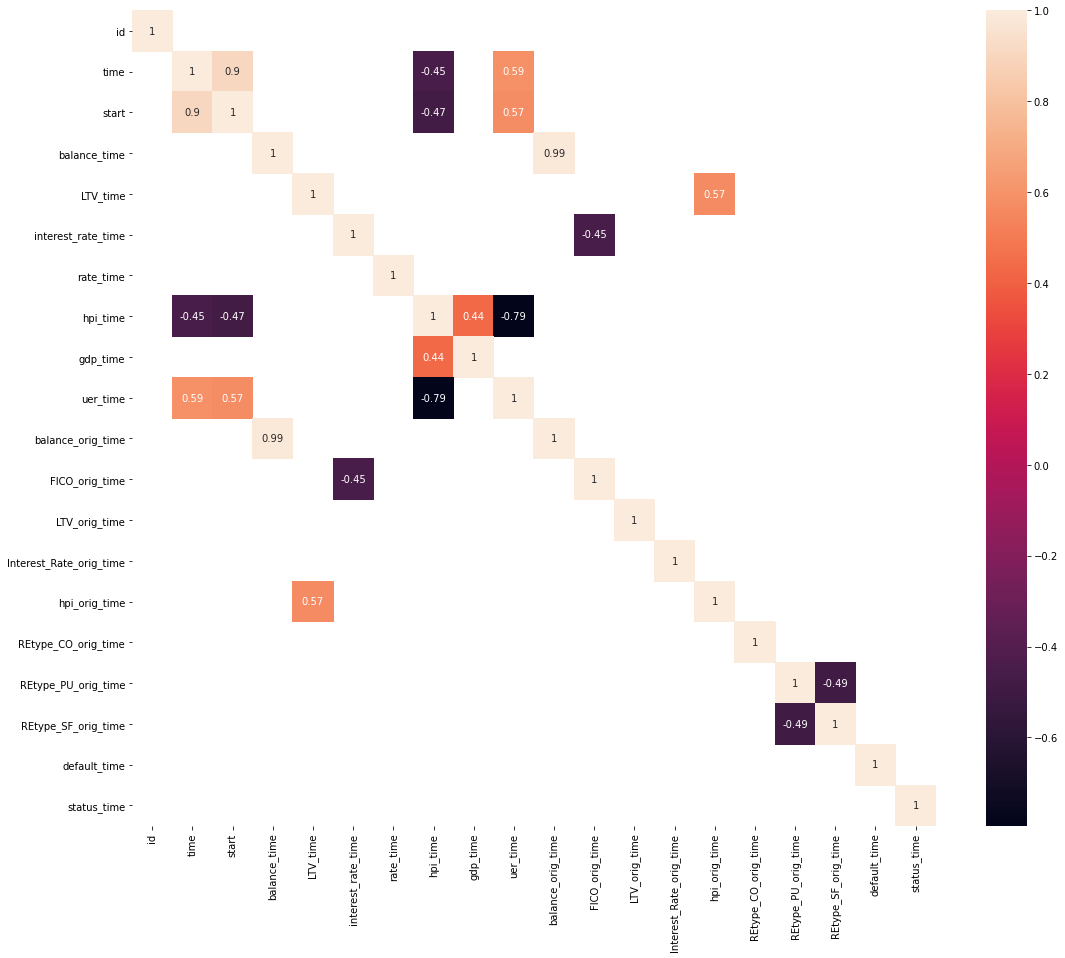

In [ ]:
import seaborn as sns

corr= df3.corr()

f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], #plot a correlation heatmap with only values exceeding absolute 0.30
            annot=True);